<a href="https://colab.research.google.com/github/yaroslavtsepkov/colab/blob/lab_0/Lab_0_gpu_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU INFO

In [47]:
!nvidia-smi

Sun Nov  1 14:58:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   1124MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Matrix multiplication
### CPU (numpy) VS GPU(cupy)


In [48]:
!pip install pycuda
!pip install scikit-cuda
from numba import cuda, float32
import numpy as np
import cupy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit
from pycuda.tools import make_default_context
import plotly.graph_objects as go

import random
import skcuda.linalg as linalg
random.seed(0)
linalg.init()
make_default_context().get_device().name()

'Tesla T4'

# Ядро 

In [49]:
kernel_code_template = """
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    float Pvalue = 0;

    for (int k = 0; k < %(MATRIX_SIZE)s; ++k) {
        float Aelement = a[ty * %(MATRIX_SIZE)s + k];
        float Belement = b[k * %(MATRIX_SIZE)s + tx];
        Pvalue += Aelement * Belement;
    }

    c[ty * %(MATRIX_SIZE)s + tx] = Pvalue;
}
"""

In [50]:
def genMatrix(n):
    return np.random.uniform(size=(n,n)).astype(np.float32)

# Перемножение матриц на CPU numpy.matmul

In [51]:
def cpuMult(n):
    size = []
    time_cpu = []
    while n < 2000:
        size.append(n)
        matrix = genMatrix(n)
        s = time.time()
        np.matmul(matrix, matrix)
        p = time.time()
        n += 50
        time_cpu.append(p-s)
    return size, time_cpu

# Перемножение матриц на GPU с cupy.matmul

In [52]:
def gpuMult(n):
    size = []
    time_gpu = []
    while n < 2000:
        size.append(n)
        matrix = cp.array(genMatrix(n))
        s = time.time()
        cp.matmul(matrix, matrix)
        p = time.time()
        n += 50
        time_gpu.append(p-s)
    return size, time_gpu

# Перемножение матриц на GPU pyCUDA

In [53]:
def gpuPyCuda(n):
    size = []
    time_pycuda = []
    while n < 2000:
        size.append(n)
        matrix = genMatrix(n)
        matrix = gpuarray.to_gpu(matrix) 
        matrix_result = gpuarray.empty((n, n), np.float32)
        kernel_code = kernel_code_template % {'MATRIX_SIZE': n}  
        mod = compiler.SourceModule(kernel_code)
        matrixmul = mod.get_function("MatrixMulKernel")
        s = time.time()
        matrixmul(matrix, matrix, matrix_result, block = (32, 32, 1),)
        p = time.time()
        n += 50
        time_pycuda.append(p-s)
    return size, time_pycuda

# Перемножение матриц на GPU skCUDA

In [54]:
def gpuSkCuda(n):
    size = []
    time_pycuda = []
    while n < 2000:
        size.append(n)
        matrix = genMatrix(n)
        matrix = gpuarray.to_gpu(matrix) 
        s = time.time()
        linalg.mdot(matrix, matrix)
        p = time.time()
        n += 50
        time_pycuda.append(p-s)
    return size, time_pycuda

# Вычисления

In [55]:
startSizeMatrix = 50

In [56]:
size_list_cpu, time_list_cpu = cpuMult(startSizeMatrix)

In [57]:
cp.cuda.Device(0).use()
size_list_gpu, time_list_gpu = gpuMult(startSizeMatrix)

In [58]:
size_list_gpu, time_pycuda = gpuPyCuda(startSizeMatrix)

In [81]:
linalg.init()
size_list_gpu, time_skcuda = gpuSkCuda(startSizeMatrix)

In [82]:
time_cpu = np.array(time_list_cpu)
time_gpu = np.array(time_list_gpu)
time_pycuda = np.array(time_pycuda)
time_skcuda = np.array(time_skcuda)

# Анализ и визуализация

In [83]:
df = pd.DataFrame({
    'size_of_matrix': size_list_cpu,
    'time_for_CPU': time_cpu,
    'time_for_GPU_cupy': time_gpu,
    'time_for_GPU_pycuda': time_pycuda,
    'time_for_GPU_skcuda': time_skcuda,
    'boost cupy & cpu': time_cpu / time_gpu,
    'boost pycuda & cpu': time_cpu/ time_pycuda,
    'boost skcuda & cpu': time_cpu/ time_skcuda,
})
df.head(5)

,size_of_matrix,time_for_CPU,time_for_GPU_cupy,time_for_GPU_pycuda,time_for_GPU_skcuda,boost cupy & cpu,boost pycuda & cpu,boost skcuda & cpu
0,50,0.000185,0.000948,0.000126,0.286447,0.195423,1.466038,0.000647
1,100,0.015213,0.000150,0.000060,0.000338,101.282540,254.215139,45.062147
2,150,0.000314,0.000060,0.000049,0.000326,5.226190,6.393204,0.963424
3,200,0.000520,0.000058,0.000052,0.000286,8.971193,10.046083,1.819699
4,250,0.000768,0.000149,0.000049,0.000401,5.143770,15.784314,1.915526


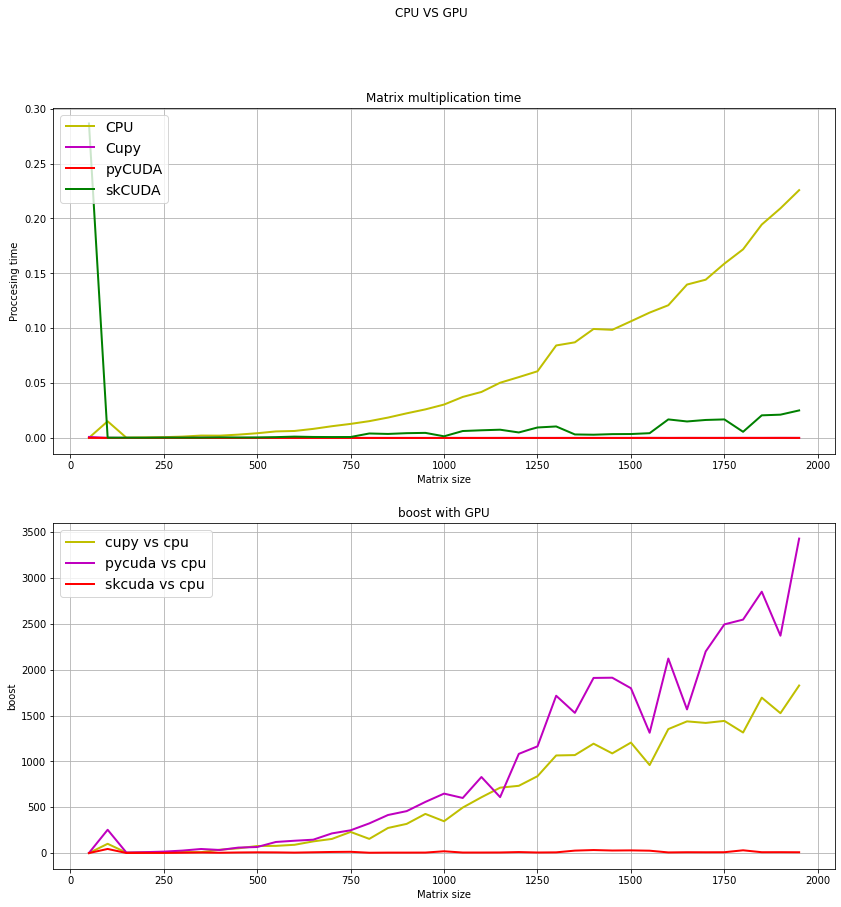

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
fig.suptitle('CPU VS GPU') 

ax1.plot(df.size_of_matrix, df.time_for_CPU, color='y', label = 'CPU', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_cupy, color='m', label = 'Cupy', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_pycuda, color='r', label = 'pyCUDA', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_skcuda, color='g', label = 'skCUDA', linewidth=2)
ax1.legend(loc="upper left", fontsize=14)
ax1.set_xlabel('Matrix size')
ax1.set_ylabel('Proccesing time')
ax1.set_title('Matrix multiplication time')
ax1.grid()

ax2.plot(df.size_of_matrix, df['boost cupy & cpu'], label = 'cupy vs cpu', color='y', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost pycuda & cpu'],label = 'pycuda vs cpu', color='m', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost skcuda & cpu'],label = 'skcuda vs cpu', color='r', linewidth=2)
ax2.legend(loc="upper left", fontsize=14)
ax2.set_xlabel('Matrix size')
ax2.set_ylabel('boost')
ax2.set_title('boost with GPU')
ax2.grid()


plt.show()
fig.savefig('plot.svg')

In [85]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_CPU'],
    name='CPU',
    mode='lines+markers',
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_GPU_cupy'],
    name='CUPY',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_GPU_pycuda'],
    name='PYCUDA',
    mode='lines+markers'
))
fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_GPU_skcuda'],
    name='skCUDA',
    mode='lines+markers'
))
fig.update_layout(
    title="Time",
    xaxis_title="size of matrix",
    yaxis_title="processing time",
    font=dict(
        size=14,
    )
)

fig.show()

In [86]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost cupy & cpu'],
    name='boost cupy & cpu',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost pycuda & cpu'],
    name='boost pycuda & cpu',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost skcuda & cpu'],
    name='skcuda & cpu',
    mode='lines+markers'
))
fig.update_layout(
    title="pucuda,cupy,skcuda vs CPU",
    xaxis_title="size of matrix",
    yaxis_title="boost",
    font=dict(
        size=14,
    )
)

fig.show()